In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [69]:
x_train = np.load("dataset/x_train.npy")/255.
x_test = np.load("dataset/x_test.npy")/255.
y_train_coarse = np.load("dataset/y_train_coarse.npy")
y_train_fine = np.load("dataset/y_train_fine.npy")

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
import pickle
with open("dataset/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("dataset/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [72]:
y_train = np.vstack([y_train_fine, y_train_coarse]).T

In [73]:
y_train.shape

(50000, 2)

In [74]:
x_train.shape

(50000, 32, 32, 3)

In [75]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

In [92]:
y_val.shape

(5000, 2)

In [93]:
x_val.shape

(5000, 32, 32, 3)

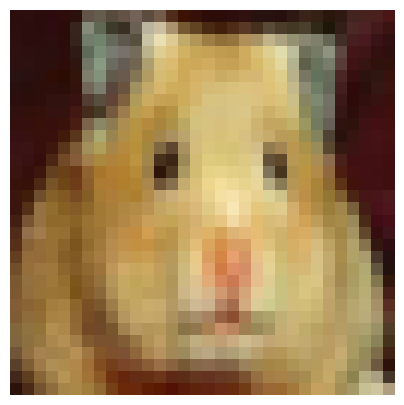

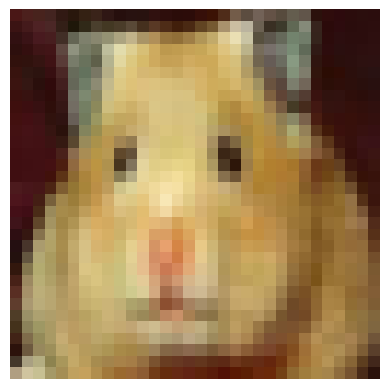

In [77]:
x_train_bis = x_train[:,:,::-1,:]
ex_idx = -1
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(x_train_bis[ex_idx])
plt.show()
plt.axis('off') 
plt.imshow(x_train[ex_idx])
plt.show()

In [79]:
labels_fine[y_train[ex_idx][0]]

'hamster'

In [80]:
x_train_dup = np.concatenate([x_train, x_train_bis],axis=0)
y_train_dup = np.concatenate([y_train, y_train], axis=0)
x_train_bis = x_train_dup.copy()
x_train_bis_bis = x_train_dup.copy()
x_train_bis[:,:,1:,:] =x_train_dup[:,:,:-1,:]
x_train_bis_bis[:,:,:-1,:] =x_train_dup[:,:,1:,:]
x_train_dup = np.concatenate([x_train_dup, x_train_bis, x_train_bis_bis],axis=0)
y_train_dup = np.concatenate([y_train_dup, y_train_dup, y_train_dup], axis=0)


In [82]:
x_train_dup.shape, y_train_dup.shape

((270000, 32, 32, 3), (270000, 2))

In [83]:
# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 10
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train_fine[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")

Grano grueso: large_natural_outdoor_scenes
Grano fino: cloud
Grano fino: forest
Grano fino: mountain
Grano fino: plain
Grano fino: sea


In [84]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import models

In [85]:

# Define model architecture
def create_model(input_shape=(32, 32, 3), l2_lambda=0.001):
    # Input layer for images
    inputs = layers.Input(shape=input_shape)
    
    # Flattening layer
    x = layers.Flatten()(inputs)
    
    # Dense layers with L2 regularization
    #x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
    
    # Parallel output layers
    fine_output = layers.Dense(100, activation='softmax', name='fine_output')(x)   # Fine-grain prediction
    coarse_output = layers.Dense(20, activation='softmax', name='coarse_output')(x) # Coarse-grain prediction
    
    # Create model
    model = models.Model(inputs=inputs, outputs=[fine_output, coarse_output])
    
    return model



In [89]:
# Instantiate the model
model = create_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'fine_output': 'sparse_categorical_crossentropy', 
        'coarse_output': 'sparse_categorical_crossentropy'
    },
    metrics=['accuracy','accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose= 1)

rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)
tb = TensorBoard(
    log_dir="logs",
)
# Display the model summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3072)      │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    786,688 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     32,896 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fine_output (Dense) │ (None, 100)       │     12,900 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ coarse_output       │ (None, 20)        │      2,580 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 835,064 (3.19 MB)

 Trainable params: 835,064 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
# Fit the model
history = model.fit(
    x=x_train_dup,                          # Input data (images)
    y={'fine_output': y_train_dup[:,1],     # Fine labels target output
       'coarse_output': y_train_dup[:,0]},# Coarse labels target output
    validation_data=(x_val, {'fine_output': y_val[:,1], 'coarse_output': y_val[:,0]}),
    epochs=50,                          # Set your number of epochs
    batch_size=32,                      # Batch size (tune as needed)
    callbacks=[tb, early_stopping]      # TensorBoard and early stopping callbacks
)

Epoch 1/2
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 63s 7ms/step - coarse_output_accuracy: 0.0135 - coarse_output_loss: 2.2260 - fine_output_accuracy: 0.0136 - fine_output_loss: 3.3601 - loss: 5.7158 - val_coarse_output_accuracy: 0.0142 - val_coarse_output_loss: 2.2050 - val_fine_output_accuracy: 0.0094 - val_fine_output_loss: 3.3522 - val_loss: 5.7111
Epoch 2/2
8438/8438 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - coarse_output_accuracy: 0.0134 - coarse_output_loss: 2.1802 - fine_output_accuracy: 0.0131 - fine_output_loss: 3.2549 - loss: 5.5808 - val_coarse_output_accuracy: 0.0110 - val_coarse_output_loss: 2.1950 - val_fine_output_accuracy: 0.0092 - val_fine_output_loss: 3.3482 - val_loss: 5.6994
Restoring model weights from the end of the best epoch: 2.


-------------------------------------------------
